In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import XGBModel, LinearRegressionModel

In [42]:
# Read and process the dataframes
cases_data = pd.read_csv('cases_1to4wk.csv').drop('Unnamed: 0', axis=1)
cases_data = cases_data.rename({'forecast_0.1' : 'cases_forecast_0.1', 'forecast_0.9' : 'cases_forecast_0.9', 'actual' : 'actual_cases'}, axis=1)
deaths_data = pd.read_csv('deaths_1to4wk.csv').drop('Unnamed: 0', axis=1)
deaths_data = deaths_data.rename({'forecast_0.1' : 'deaths_forecast_0.1', 'forecast_0.9' : 'deaths_forecast_0.9', 'actual' : 'actual_deaths'}, axis=1)
# Merge the dataframes on 'target_end_date' and 'ahead'
df = pd.merge(cases_data, deaths_data, on=['target_end_date', 'ahead', 'forecast_date'])
df['target_end_date'] = df['target_end_date'].astype('datetime64[ns]')
df['forecast_date'] = df['forecast_date'].astype('datetime64[ns]')

In [43]:
# Calculate score functions
df['cases_score_upper'] =  (df['actual_cases'] - df['cases_forecast_0.9'])  / df['actual_cases']
df['cases_score_lower'] =  (df['cases_forecast_0.1'] - df['actual_cases'])  / df['actual_cases']
df['deaths_score_upper'] = (df['actual_deaths'] - df['deaths_forecast_0.9']) /10000      #/ df['actual_deaths']
df['deaths_score_lower'] = (df['deaths_forecast_0.1'] - df['actual_deaths']) /10000      #/ df['actual_deaths']

<AxesSubplot:xlabel='target_end_date', ylabel='cases_score_upper'>

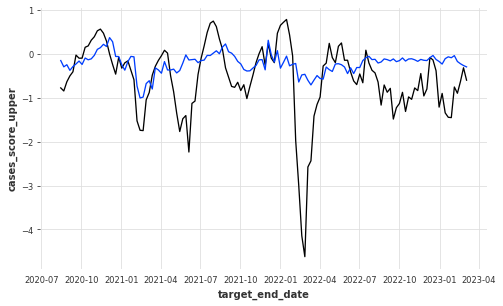

In [44]:
# Plot score functions
plt.figure(figsize=(8,4.8))
sns.lineplot(data=df[df.ahead == 4], x='target_end_date', y='cases_score_upper')
sns.lineplot(data=df[df.ahead == 4], x='target_end_date', y='deaths_score_upper')

<AxesSubplot:xlabel='target_end_date', ylabel='cases_score_lower'>

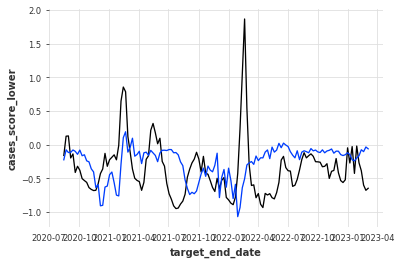

In [5]:
# Plot score functions
sns.lineplot(data=df[df.ahead == 4], x='target_end_date', y='cases_score_lower')
sns.lineplot(data=df[df.ahead == 4], x='target_end_date', y='deaths_score_lower')

In [6]:
# Create TimeSeries objects
df_4wk = df[df.ahead == 4].dropna()
cases_series_upper = TimeSeries.from_dataframe(df_4wk, time_col='target_end_date', value_cols='cases_score_upper')
deaths_series_upper = TimeSeries.from_dataframe(df_4wk, time_col='target_end_date', value_cols='deaths_score_upper')

model_upper = XGBModel(lags=[-4, -5, -6], lags_past_covariates=1, quantiles=0.90)

# Perform the backtesting
past_covariates_upper = cases_series_upper.shift(4)  # Shift the cases data by 4 periods
death_score_upper_forecasts = model_upper.historical_forecasts(deaths_series_upper, past_covariates = past_covariates_upper)

In [22]:
# post-process forecasts not to change too much per week
def post_process(ts, max_change=0.2):
    # convert TimeSeries to pandas DataFrame
    df = ts.pd_dataframe()
    
    for col in df.columns:
        processed = [df[col].iloc[2]]  # initialize with the first forecast
        for forecast in df[col].iloc[1:]:
            previous = processed[-1]
            if abs(forecast - previous) > max_change:
                # if change is more than allowed, adjust the forecast
                processed.append(previous + max_change if forecast > previous else previous - max_change)
            else:
                processed.append(forecast)
        df[col] = processed
    
    # convert DataFrame back to TimeSeries
    processed_ts = TimeSeries.from_dataframe(df.rename_axis('target_end_date', axis='index'))
    return processed_ts

# Apply the post-processing function to the forecasted data
proc_death_score_upper_forecasts = post_process(death_score_upper_forecasts)

In [8]:
# Create TimeSeries objects
df_4wk = df[df.ahead == 4].dropna()
cases_series_lower = TimeSeries.from_dataframe(df_4wk, time_col='target_end_date', value_cols='cases_score_lower')
deaths_series_lower = TimeSeries.from_dataframe(df_4wk, time_col='target_end_date', value_cols='deaths_score_lower')

model_lower = XGBModel(lags=[-4, -5, -6], lags_past_covariates=1, quantiles=0.90)

# Perform the backtesting
past_covariates_lower = cases_series_lower.shift(4)  # Shift the cases data by 1 period
death_score_lower_forecasts = model_lower.historical_forecasts(deaths_series_lower, past_covariates = past_covariates_lower)

In [23]:
proc_death_score_lower_forecasts = post_process(death_score_lower_forecasts)

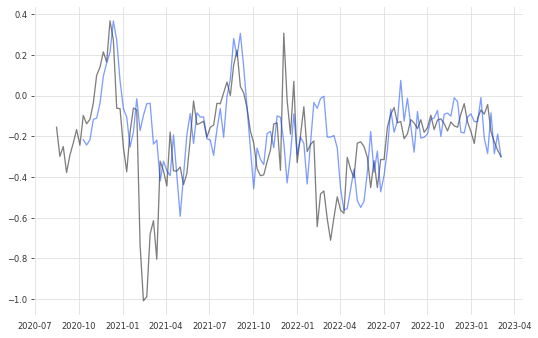

In [24]:
plt.figure(figsize=(7.6,4.8))
plt.plot(np.array(deaths_series_upper._time_index), deaths_series_upper.values(), alpha=0.5)
plt.plot(np.array(death_score_upper_forecasts.time_index), proc_death_score_upper_forecasts.values(), alpha=0.5)
plt.tight_layout()

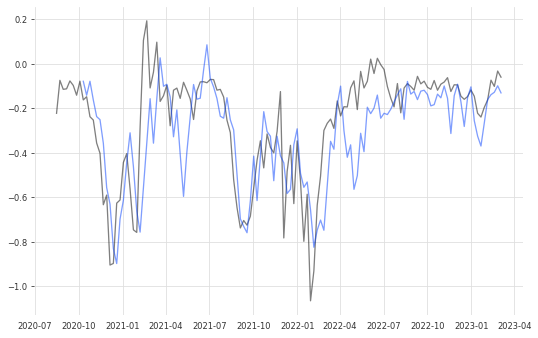

In [25]:
plt.figure(figsize=(7.6,4.8))
plt.plot(np.array(deaths_series_lower._time_index), deaths_series_lower.values(), alpha=0.5)
plt.plot(np.array(death_score_lower_forecasts.time_index), proc_death_score_lower_forecasts.values(), alpha=0.5)
plt.tight_layout()

In [26]:
# Create a dataset for use with the base framework
dataset = deaths_series_lower.pd_dataframe().rename({'deaths_score_lower' : 'score_lower'}, axis=1).merge(
    deaths_series_upper.pd_dataframe().rename({'deaths_score_upper' : 'score_upper'}, axis=1), on='target_end_date').merge(
    proc_death_score_lower_forecasts.pd_dataframe().rename({'deaths_score_lower' : 'scorecast_lower'}, axis=1), on='target_end_date').merge(
    proc_death_score_upper_forecasts.pd_dataframe().rename({'deaths_score_upper' : 'scorecast_upper'}, axis=1), on='target_end_date').astype(float)
dataset = dataset.merge(df[df.ahead == 4].drop(['actual_cases', 'cases_forecast_0.1', 'cases_forecast_0.9', 'ahead', 'cases_score_upper', 'cases_score_lower', 'deaths_score_upper', 'deaths_score_lower'], axis=1), on='target_end_date')

dataset['scores'] = [np.array([dataset['score_lower'][j]*10000, dataset['score_upper'][j]*10000]) for j in range(len(dataset))]
dataset['scorecasts'] = [np.array([dataset['scorecast_lower'][j]*10000, dataset['scorecast_upper'][j]*10000]) for j in range(len(dataset))]
dataset['forecasts'] = [np.array([dataset['deaths_forecast_0.1'][j], dataset['deaths_forecast_0.9'][j]]) for j in range(len(dataset))]
dataset = dataset.drop(['score_lower', 'score_upper', 'scorecast_lower', 'scorecast_upper', 'deaths_forecast_0.1', 'deaths_forecast_0.9', 'forecast_date'], axis=1).rename({'target_end_date' : 'timestamp', 'actual_deaths' : 'y'}, axis=1).melt(id_vars=['timestamp'], value_name='target')

In [27]:
dataset.to_pickle('./proc_4wkdeaths.pkl')